(4177, 9)
gender             object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object
(4177, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          4177 non-null   float64
 1   Diameter        4177 non-null   float64
 2   Height          4177 non-null   float64
 3   Whole weight    4177 non-null   float64
 4   Shucked weight  4177 non-null   float64
 5   Viscera weight  4177 non-null   float64
 6   Shell weight    4177 non-null   float64
 7   Rings           4177 non-null   int64  
 8   gender_I        4177 non-null   bool   
 9   gender_M        4177 non-null   bool   
dtypes: bool(2), float64(7), int64(1)
memory usage: 269.3 KB
None


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,gender_I,gender_M
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177,4177
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2835,2649
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684,NaN,NaN
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169,NaN,NaN
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000,NaN,NaN
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000,NaN,NaN
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000,NaN,NaN
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000,NaN,NaN



Missing values per column:
 Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
gender_I          0
gender_M          0
dtype: int64


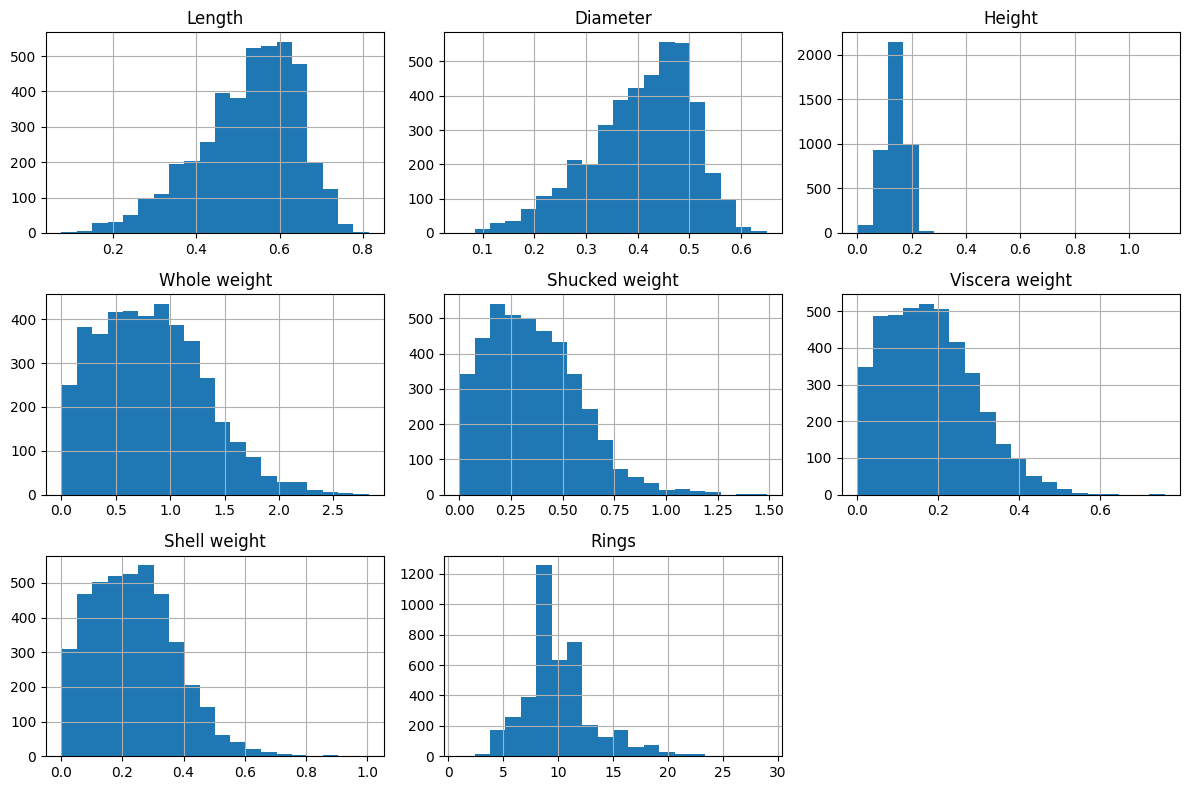

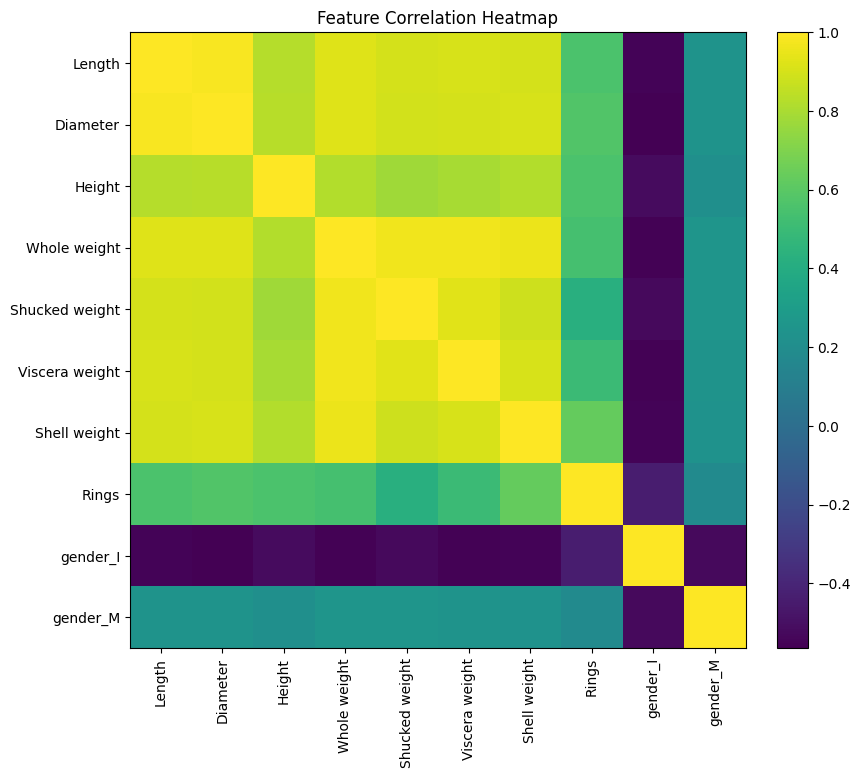

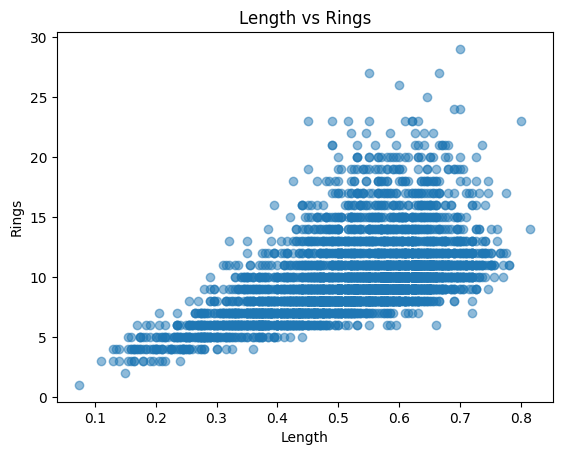

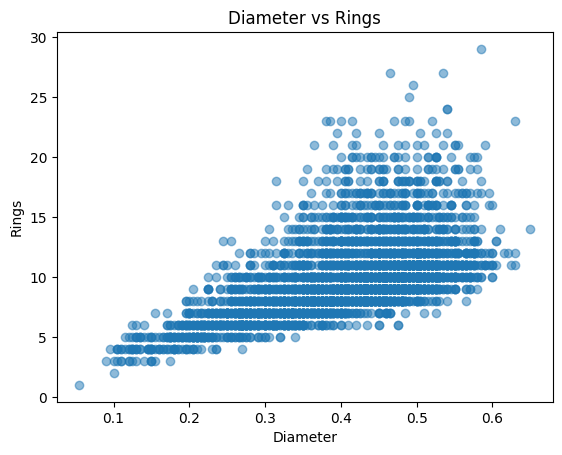

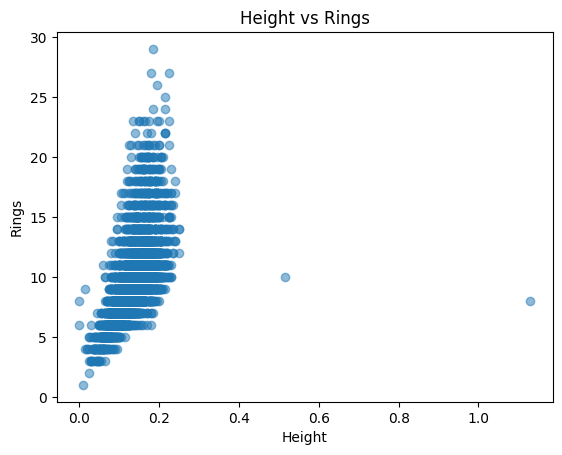

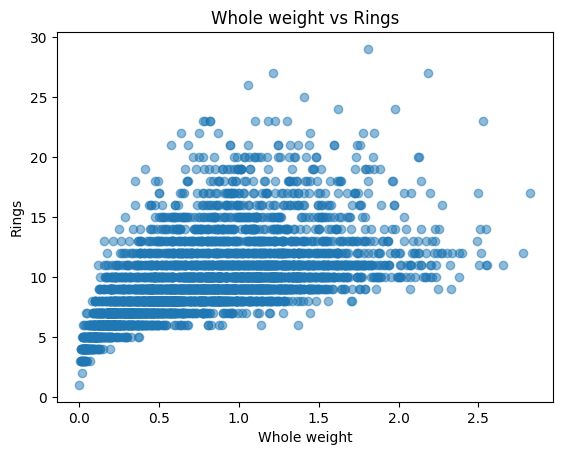

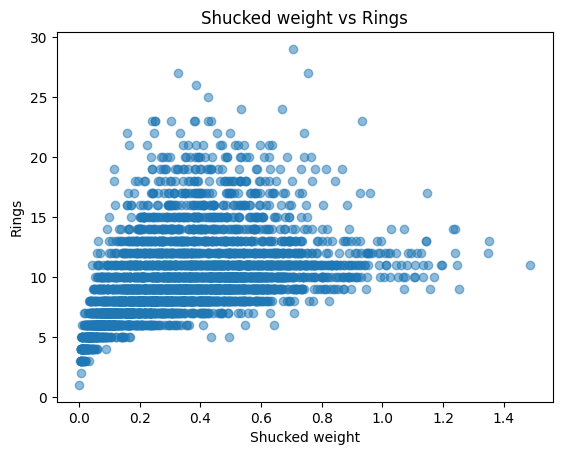

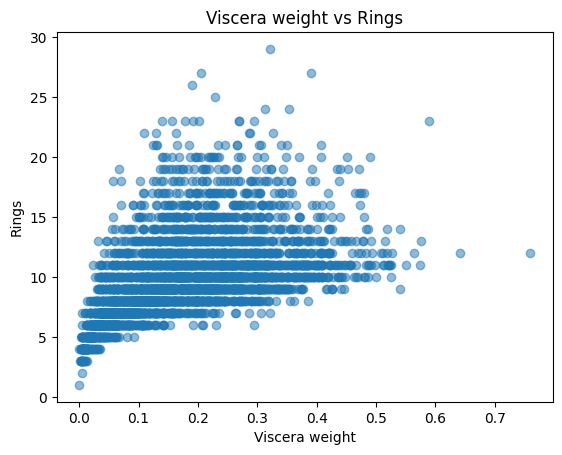

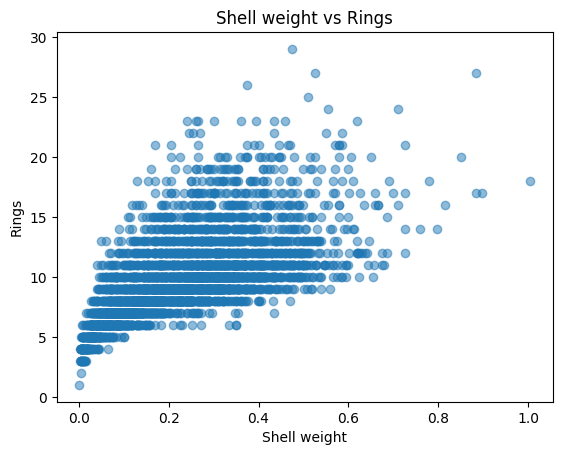

Linear Regression Metrics: {'RMSE': np.float64(2.2116130871218367), 'MAE': 1.5931067816608366, 'R2': 0.5481628137889263, 'train_time': 0.007059335708618164, 'pred_time': 0.00141143798828125}
Best Ridge alpha: {'model__alpha': 0.1}
Ridge Regression Metrics: {'RMSE': np.float64(2.211595249946187), 'MAE': 1.593190295976365, 'R2': 0.5481701021042301, 'train_time': 0.005224704742431641, 'pred_time': 0.001737833023071289}


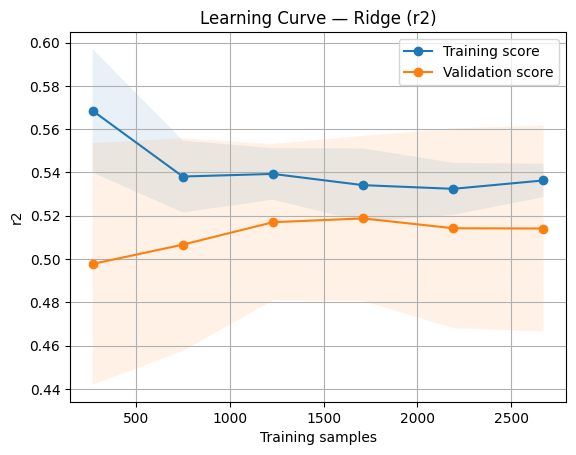

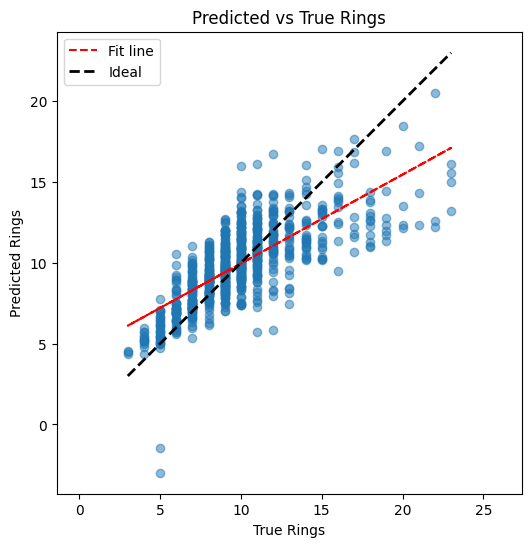

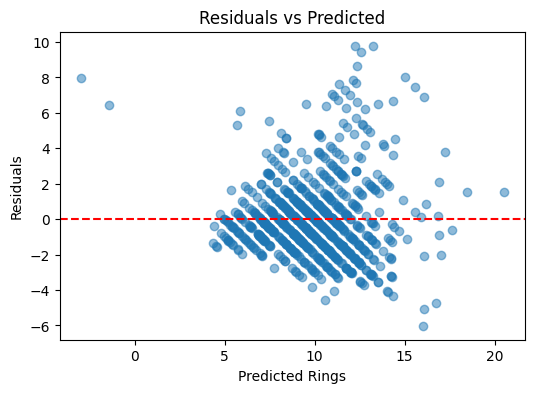

In [2]:
# --- IMPORTS ---
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, learning_curve, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For reproducibility
RNG = 42
np.random.seed(RNG)


# Load Data:
DATA_PATH = r"abalone.data.csv" 

# First row is header
abalone = pd.read_csv(DATA_PATH, sep=",", header=0)
df = pd.read_csv(DATA_PATH, sep=",", header=0)
assert "Rings" in df.columns, "Expected 'Rings' column."
print(df.shape)
print(df.dtypes)
df.head()

# --- FUNCTIONS ---

def load_and_preprocess(path):
    """
    Load the dataset and preprocess:
    - Convert numeric columns
    - One-hot encode categorical 'gender'
    - Handle missing values
    """
    df = pd.read_csv(path, sep=",", header=0)
    assert "Rings" in df.columns, "Expected 'Rings' column."
    
    # Convert numeric columns
    numeric_cols = df.columns.drop("gender")
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    
    # Handle missing values
    df = df.dropna()
    
    # One-hot encode gender
    df = pd.get_dummies(df, columns=["gender"], drop_first=True)
    
    return df


def explore_data(df):
    """
    Perform EDA: summary stats, distributions, correlations
    """
    display(df.describe(include='all'))
    print("\nMissing values per column:\n", df.isna().sum())
    
    # Histograms for numeric features
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols].hist(figsize=(12,8), bins=20)
    plt.tight_layout()
    plt.show()
    
    # Correlation heatmap (matplotlib only)
    corr = df.corr()
    plt.figure(figsize=(10,8))
    im = plt.imshow(corr, interpolation='none')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr)), corr.columns, rotation=90)
    plt.yticks(range(len(corr)), corr.columns)
    plt.title("Feature Correlation Heatmap")
    plt.show()
    
    # Scatter plots of features vs target
    for col in numeric_cols:
        if col != "Rings":
            plt.figure()
            plt.scatter(df[col], df["Rings"], alpha=0.5)
            plt.xlabel(col)
            plt.ylabel("Rings")
            plt.title(f"{col} vs Rings")
            plt.show()


def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Train model, evaluate on test set, return metrics and predictions
    """
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0
    
    t1 = time.time()
    y_pred = model.predict(X_test)
    pred_time = time.time() - t1
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics = {"RMSE": rmse, "MAE": mae, "R2": r2,
               "train_time": train_time, "pred_time": pred_time}
    return metrics, y_pred


def plot_learning_curve(model, X, y, cv, metric="r2"):
    """
    Plot learning curve for given model
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring=metric, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=RNG
    )
    plt.figure()
    plt.title(f"Learning Curve — {model.named_steps['model'].__class__.__name__} ({metric})")
    plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training score")
    plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation score")
    plt.fill_between(train_sizes, 
                     train_scores.mean(axis=1)-train_scores.std(axis=1),
                     train_scores.mean(axis=1)+train_scores.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, 
                     val_scores.mean(axis=1)-val_scores.std(axis=1),
                     val_scores.mean(axis=1)+val_scores.std(axis=1), alpha=0.1)
    plt.xlabel("Training samples")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_predictions(y_true, y_pred):
    """
    Scatter plot of predicted vs true values with line of best fit and diagonal
    """
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel("True Rings")
    plt.ylabel("Predicted Rings")
    plt.title("Predicted vs True Rings")
    
    # Line of best fit
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_true, p(y_true), "r--", label="Fit line")
    
    # Diagonal reference
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label="Ideal")
    
    plt.axis('equal')
    plt.legend()
    plt.show()


def plot_residuals(y_true, y_pred):
    """
    Residual plot to check bias and variance
    """
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.xlabel("Predicted Rings")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Predicted")
    plt.show()


# --- MAIN PIPELINE ---

# Load and preprocess
DATA_PATH = "abalone.data.csv"  # adjust path if needed
df = load_and_preprocess(DATA_PATH)
print(df.shape)
print(df.info())

# Explore
explore_data(df)

# Split data
X = df.drop(columns=["Rings"])
y = df["Rings"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RNG)

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=RNG)

# Baseline Linear Regression
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])
lin_metrics, lin_pred = evaluate_model(lin_pipe, X_train, y_train, X_test, y_test)
print("Linear Regression Metrics:", lin_metrics)

# Ridge Regression with hyperparameter tuning
ridge_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(random_state=RNG))
])
param_grid = {"model__alpha": [0.1, 1.0, 10.0, 50.0]}
grid = GridSearchCV(ridge_pipe, param_grid, cv=kf, scoring="r2", n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Ridge alpha:", grid.best_params_)

ridge_metrics, ridge_pred = evaluate_model(grid.best_estimator_, X_train, y_train, X_test, y_test)
print("Ridge Regression Metrics:", ridge_metrics)

# Learning Curve
plot_learning_curve(grid.best_estimator_, X_train, y_train, cv=kf, metric="r2")

# Predicted vs True
plot_predictions(y_test, ridge_pred)

# Residuals
plot_residuals(y_test, ridge_pred)
